# A2 Problems

### Problem 1

We want to write a function modelling $\log_2$ valid from 0.5 to 1 with an accuracy better than $10^{-6}$. For this we'll use a truncated Chebyshev polynomial fit. Recall Chebyshev polynomials are:

$$P_0(x) = 1$$
$$P_1 (x) = x$$
$$P_{n+1} (x) = 2xP_n(x) - P{n-1} (x) \quad (n > 0)$$

We must write our own fit routine, and we'll use the $\chi^2$ minimization technique. Recall from class the matrix equation we derived to find fit parameters for a linear model using $\chi^2$ minimization is:

$$A^T N^{-1} A m = A^T N^{-1} x$$
$$\implies m = (A^T N^{-1} A)^{-1} A^T N^{-1} x$$

where $A$ is the matrix containing the values for each function of $x$ in our model, $m$ are the fit coefficients (which we are solving for), $N$ is the noise matrix (e.g. for uncorrelated errors N is $\sigma_i^2$ on the diagonal), and $x$ are the $x$ values of the data.

Let's implement a function to retrieve our Chebyshev polynomial matrix $A$, and a $\chi^2$ minimization function. Note we also need to translate the range of our data to the range of the chebyshev polynomials, which is easy to do considering the equations
$$x_{\text{Cheby, min}} = ax_{\text{data, min}} + b$$
$$x_{\text{Cheby, max}} = ax_{\text{data, max}} + b$$
And the equation can be constructed after solving for $a$ and $b$
$$x_{\text{Cheby}} = ax_{\text{data}} + b$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def map_to_chebyshev_boundaries(x):
    '''
    Linearly map values in x to be within the chebyshev range -1 to 1
    
    PARAMETERS:
    -----------
    x : array-like
        The array of x values in your data points
    
    RETURNS:
    --------
    x_mapped : array-like
        The array of x values mapped linearly to the chebyshev domain
    '''
    # Mapping using y = a*x + b where x and y are data and Chebyshev locations 
    # respectively
    cheby_min = -1
    cheby_max = 1
    a = (cheby_max - cheby_min)/(x.max() - x.min())
    b = cheby_min - a*x.min()
    x_mapped = a*x + b
    return x_mapped

def chebyshev_matrix(x, ord):
    '''
    Create a matrix for use in least squares fitting with Chebyshev
    polynomials
    
    PARAMETERS:
    -----------
    x : array-like
        The array of x values in your data points
    ord : int
        Order of the polynomial to fit
        
    Returns:
    --------
    mat : array-like
        A matrix containing function evaluations on x for each Chebyshev
        polynomial up to the desired order
    '''
    x = map_to_chebyshev_boundaries(x)
    nx = len(x)
    mat = np.zeros([nx, ord+1])
    # Zeroth order polynomial
    mat[:,0] = 1.0
    # First order polynomial
    if ord > 0:
        mat[:,1] = x
    # n > 1 order polynomials
    if ord > 1:
        for i in range(1, ord):
            mat[:,i+1] = 2*x*mat[:,i]-mat[:,i-1]
    return mat

def fit_chisq(data, A):
    '''
    Perform a chi squared minimization fit
    
    PARAMETERS:
    -----------
    data : array-like
        The function values for our data points
    A : array-like
        The n_pars by n_data array containing information about the function
        values for each term in our model
        
    RETURNS:
    --------
    fitp : array-like
        An array of the best fit values of coefficients for each term in our
        linear model
    '''
    # NOTE: if we don't have errors for our data (the function evaluation is exact), 
    # then we remove the noise matrix multiplication in our fit
    # Using SVD composition as seen in class so that higher order polynomials can 
    #be obtained without having to worry as much about condition number issues
    U, S, V_T = np.linalg.svd(A,False)
    S_1 = np.diag(1/S)
    fitp = V_T.T@S_1@U.T@data
    return fitp

Let's try a basic Chebyshev fit just to test our functions. We'll use five Chebyshev polynomials, and plot the residuals to make sure everything works as expected.

In [3]:
# Create an array of x values
x = np.linspace(0.5, 1, 1000)
# Choose a degree for cheby fit
n_poly = 5
# Make the Chebyshev matrix A
A = chebyshev_matrix(x, n_poly)
# Make a matrix for the real data values
y = np.log2(x)

In [4]:
# Get fit pars
test_fitp = fit_chisq(y, A)
# Multiply fit pars by A to get our model prediction
pred = np.dot(A, test_fitp)

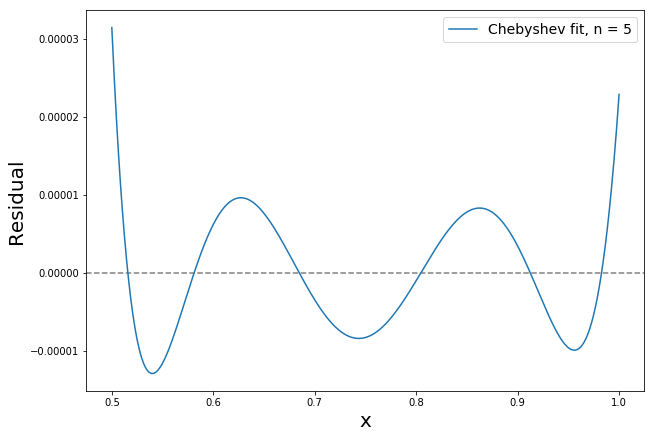

In [5]:
plt.figure(figsize=(10,7))
plt.axhline(0, color = "grey", linestyle="--")
plt.plot(x, pred-y, label="Chebyshev fit, n = {}".format(n_poly))
plt.xlabel("x",fontsize=20)
plt.ylabel("Residual",fontsize=20)
plt.legend(fontsize="14")
plt.show()

In [6]:
# Check out the maximum error
abs(pred-y).max()

3.143071472011538e-05

Great! Our fit looks good, and the residual has an expected sinusoidal behaviour due to the Chebyshev polynomails being defined by the double angle formula. Now, we must have accuracy better than $10^{-6}$ in the region. Let's fit a high order polynomial $n=50$, and figure out how many terms we need to retain this accuracy. Once we have that number of terms, we'll also perform a non-truncated fit to compare to the truncated one to view how the residuals behave, as well as the RMS error. Further, we'll perform a polynomial fit with `np.polyfit` and see how those errors compare.

In [7]:
n_poly = 50
A = chebyshev_matrix(x, n_poly)
fitp = fit_chisq(y, A)

In [8]:
# We'll start with just the first truncated chebyshev fit, and work up until the error
# is sufficient in our region
n_trunc = 1
pred = A[:,:n_trunc]@fitp[:n_trunc]
while abs(pred-y).max() > 1e-6 and n_trunc < n_poly:
    n_trunc = n_trunc + 1
    pred = A[:,:n_trunc]@fitp[:n_trunc]
    print("Max error for n_trunc = {} is {}".format(n_trunc, abs(pred-y).max()))
print("Number of polynomials truncated from n = 50 Chebyshev fit required for error within 1e-6: {}".format(n_trunc))

Max error for n_trunc = 2 is 0.048051933767759625
Max error for n_trunc = 3 is 0.005582956978329778
Max error for n_trunc = 4 is 0.0007252740070965435
Max error for n_trunc = 5 is 0.00010018903126252088
Max error for n_trunc = 6 is 1.4390929996888069e-05
Max error for n_trunc = 7 is 2.12374089247902e-06
Max error for n_trunc = 8 is 3.196978299868647e-07
Number of polynomials truncated from n = 50 Chebyshev fit required for error within 1e-6: 8


In [9]:
A_non_trunc = chebyshev_matrix(x, n_trunc - 1)
fitp_non_trunc = fit_chisq(y, A_non_trunc)
pred_non_trunc = A_non_trunc@fitp_non_trunc

In [10]:
# Get our polynomial fit. Note coeffs are the polynomial coefficients from largest
# to smallest degree! So I reverse the returned array.
coeffs = np.polyfit(x, y, n_trunc - 1)
coeffs = coeffs[::-1]
y_poly = 0
for i, coeff in enumerate(coeffs):
    y_poly += coeff*x**i

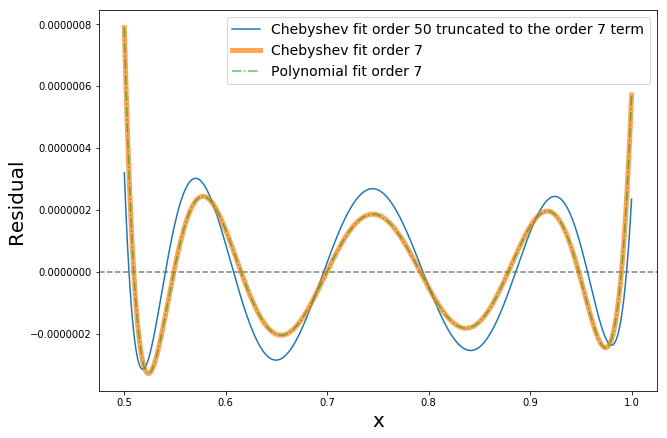

In [11]:
r = pred - y
r_non_trunc = pred_non_trunc - y
r_poly = y_poly - y
plt.figure(figsize=(10,7))
plt.axhline(0, color="grey", linestyle="--")
plt.plot(x, r, label="Chebyshev fit order {} truncated to the order {} term".format(n_poly,n_trunc-1))
plt.plot(x, r_non_trunc, label="Chebyshev fit order {}".format(n_trunc-1), linewidth=5, alpha=0.7)
plt.plot(x, r_poly, label="Polynomial fit order {}".format(n_trunc-1), alpha=0.7, linestyle='-.')
plt.xlabel("x",fontsize=20)
plt.ylabel("Residual",fontsize=20)
plt.legend(fontsize="14")
plt.show()

In [12]:
print("Max error for non-truncated: {}".format(pred_non_trunc.max()))
print("Max error for truncated: {}".format(pred.max()))
print("Max error for polynomial: {}".format(y_poly.max()))
print("RMS error for non-truncated: {}".format(r_non_trunc.std()))
print("RMS error for truncated: {}".format(r.std()))
print("RMS error for truncated: {}".format(r_poly.std()))

Max error for non-truncated: 5.710140393716534e-07
Max error for truncated: 2.3504788178307923e-07
Max error for polynomial: 5.710140429382449e-07
RMS error for non-truncated: 1.6852518246893844e-07
RMS error for truncated: 1.919202003626461e-07
RMS error for truncated: 1.6852518250016322e-07


We can see that the max error for the non-truncated fit is larger, but the RMS error for the non-truncated fit is better. The truncated fit is momre consistent, deviating about the same as average at the endpoints. The polynomial fit does pretty much the exact same as our Chebyshev fit, which means our fitting routine is just as good as numpy's! Cool!

Now we need to expand this to work on any number. We will use `np.frexp` to do this. What `np.frexp` does is divide any given number into a mantissa $m$ and exponent $\epsilon$:

$$x = m\times 2^{\epsilon}$$

This is very useful for our case of expanding the domain of our `log2` function because when taking the logarithm of a number expanded this way we obtain:

$$y = \log_2 x = log_2 m + \epsilon$$

This decomposition is so useful because the mantissa will always be within the range we already set for our logarithm -- 0.5 to 1!

So, all we have to do to get our function to work for any real number is to take the `frexp` decomposition, use our function on the mantissa $m$ which lies in the range our function works well, and then add the exponent. In order to estimate the log of $m$, we'll note that we can say
$$log_2 m = y - \epsilon$$

In [13]:
# Make a set of x and y values up to large numbers
x_large_range = np.logspace(-5, 5, 1000)
y_large_range = np.log2(x_large_range)
m, exp = np.frexp(x_large_range)

In [14]:
A_large_range = chebyshev_matrix(m, n_trunc - 1)
fitp_large_range = fit_chisq(y_large_range - exp, A_large_range)
# Adding the exponent to the predicted value, as we predicted log2 of the mantissa,
# and y = log2(m) + exp!
pred_large_range = A_large_range@fitp_large_range + exp

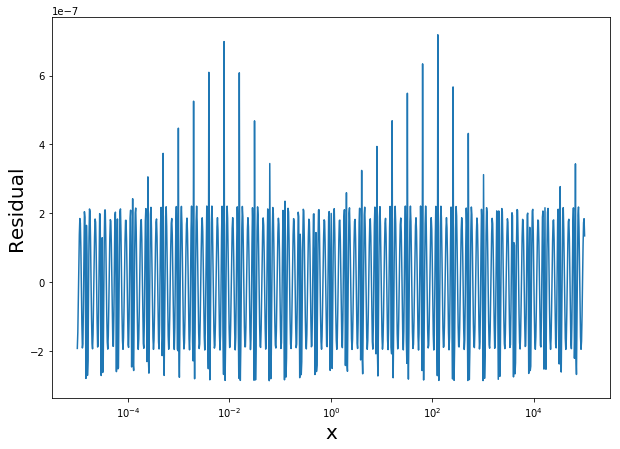

Max error for large range: 7.184108739011208e-07
RMS error for large range: 1.6858979486148243e-07


In [15]:
# Ensure our fit does a good job for the large range of x values
r_large_range = pred_large_range - y_large_range
plt.figure(figsize=(10,7))
plt.semilogx(x_large_range, r_large_range)
plt.xlabel("x",fontsize=20)
plt.ylabel("Residual",fontsize=20)
plt.show()
print("Max error for large range: {}".format(r_large_range.max()))
print("RMS error for large range: {}".format(r_large_range.std()))

### Problem 2

We want to fit a flare to data from TESS. We'll model the flare as an exponential decay starting at some time. First, let's take a look at the data!

In [16]:
data = np.loadtxt("229614158_PDCSAP_SC6.txt", delimiter=",")
time = data[:,0]
flux = data[:,1]

Text(0.5, 0, 'Time')

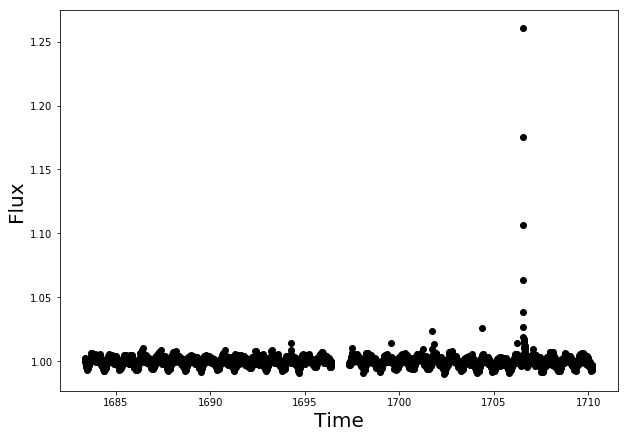

In [17]:
plt.figure(figsize=(10,7))
plt.plot(time, flux, 'ko')
plt.ylabel("Flux", fontsize=20)
plt.xlabel("Time", fontsize=20)

Alright, so there's a whole bunch of data that isn't around the flare window we probably don't care about. There's clearly a periodic feature around the baseline noise that probably has to do with an orbital feature, but we won't worry about that. Let's zoom in around $t=1706$:

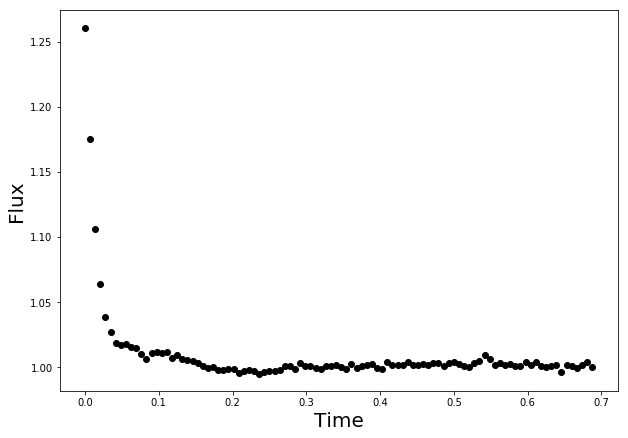

In [18]:
plt.figure(figsize=(10,7))
# Find the time of max flux, call it the flare time, trim to just the flare region
flare_time = np.argmax(flux)
time_trimmed = time[flare_time:flare_time+100] - time[flare_time]
flux_trimmed = flux[flare_time:flare_time+100]
plt.plot(time_trimmed, flux_trimmed, 'ko')
plt.ylabel("Flux", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.show()

Cool, this looks much more manageable to fit. Originally, if we were fitting the full data stream, we would have had to include a term in our exponential function dealing with the flare time:

$$f(t) = ae^{-(t - t_0)/b} + c$$

where $t_0$ is the flare time, $b$ is the exponential decay rate, and $c$ is just a constant offset. Our starting guess for $t_0$ will be $t=0$ as we set the maximum flux value as the flare time and cut our data.

To get some starting guess values, I just fiddled around with various values until I found something that seems reasonable. To do things more iteratively/computationally, once could make an array of values and find the best chisq looping over a number of different options. Note that I chose $c=1$ beforehand as that seems very reasonable looking at the data.

In [19]:
def exp_model(t, a, b, c):
    '''
    An exponential model to fit a flare
    
    PARAMETERS:
    -----------
    t : array-like
        The time values for the data to be fit
    a : float
        The coefficient for the exponential term
    b : float
        The decay constant
    c : float
        The constant offset
    '''
    return a*np.exp(-t/b) + c

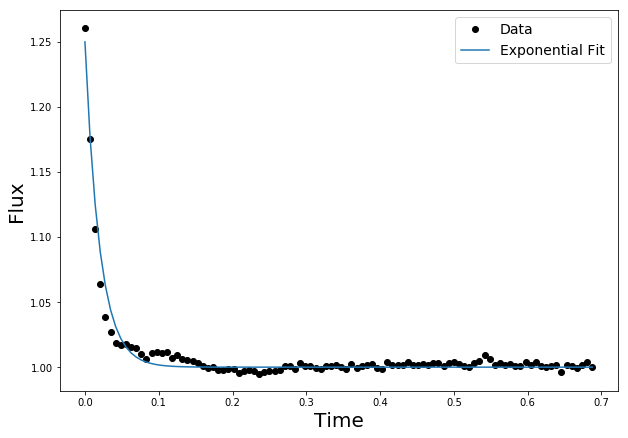

In [20]:
# Fiddled around with these while plotting (keeping c=1) to get a reasonable
# starting guess
a = 0.25
b = 1/50
c = 1.0
flux_model = exp_model(time_trimmed, a, b, c)
plt.figure(figsize=(10,7))
plt.plot(time_trimmed, flux_trimmed, 'ko', label="Data")
plt.plot(time_trimmed, flux_model, label="Exponential Fit")
plt.ylabel("Flux", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.legend(fontsize=14)
plt.show()

Now we need to optimize this fit using Newton's method. Recall from class that minimizing the gradient of $\chi^2$ with respect to parameters $m$, when linearizing, we get an expression:

$$A_m^T N^{-1} A_m \delta m = A_m^T N^{-1} r$$
$$\implies \delta m = \left(A_m^T N^{-1} A_m\right)^{-1} A_m^T N^{-1} r$$

where $A_m = \frac{\partial A}{\partial m}$ and $r$ are the residuals (data - model). Newton's method procedure is as follows:
- Start with a guess for $m_0$
- Calculate $A(m_0)$ and local gradient $A_m$
    - The local gradient can be calculated for each parameter by just taking the derivative of our model for each parameter
- Solve the linear system above for $\delta m$ and iterate $m_{\text{new}} = m_0 + \delta_m$
- Repeat until $\delta m$ is small ($\chi^2 << 1$)

In [21]:
# Write a function to minimize chisq using newton's method for our function
def newton_minimizer(time, flux, flux_model, m):
    '''
    Use Newton's method to find best-fit parameters for our exponential
    decay model
    '''
    derivs = np.zeros((len(flux), len(m)))
    exp = np.exp(-time/m[1])
    # Derivative wrt a
    derivs[:,0] = exp
    # Derivative wrt b
    derivs[:,1] = m[0]*time*exp/(m[1]**2)
    # Derivative wrt c
    derivs[:,2] = np.ones(len(flux))
    
    # So now our derivs array is equivalent to A_m. Our residual array is then:
    r = flux - flux_model
    
    # Now calculate delta_m
    delta_m = np.linalg.inv(derivs.T@derivs)@derivs.T@r
    m_new = m + delta_m
    return m_new, delta_m

# Quick chisq calculator
def calc_chisq(data, model):
    return np.sum((data - model)**2)

Iteration 1, delta chisq is -0.001828464955614721
Iteration 2, delta chisq is -1.840004277080796e-05
Iteration 3, delta chisq is -3.172024153541217e-09


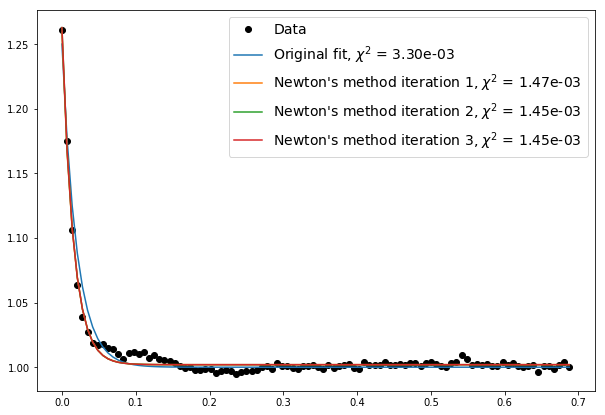

In [22]:
#Setup original pars + chisq + fit
m = np.array([a,b,c])
old_chisq = calc_chisq(flux_trimmed, flux_model)
delta_chisq = 1000
plt.figure(figsize=(10,7))
plt.plot(time_trimmed, flux_trimmed, "ko", label="Data")
plt.plot(time_trimmed, flux_model, label="Original fit, $\chi^2$ = %.2e" % (old_chisq))
i = 1
# Iterate on Newton's method
while True:
    # Call our minimizer, get a new fit + chisq
    m, delta_m = newton_minimizer(time_trimmed, flux_trimmed, flux_model, m)
    flux_model = exp_model(time_trimmed, *m)
    new_chisq = calc_chisq(flux_trimmed, flux_model)
    # delta_chisq should be negative if new_chisq is lower than old_chisq
    delta_chisq = new_chisq - old_chisq
    print("Iteration {}, delta chisq is {}".format(i, delta_chisq))
    # If deltachisq << 1, break out of loop
    if abs(delta_chisq) < 1e-5:
        plt.plot(time_trimmed, flux_model, label="Newton's method iteration %s, $\chi^2$ = %.2e" % (i, old_chisq))
        break
    # Else keep iterating
    else:
        old_chisq = new_chisq
        plt.plot(time_trimmed, flux_model, label="Newton's method iteration %s, $\chi^2$ = %.2e" % (i, old_chisq))
        i += 1
plt.legend(fontsize=14)
plt.show()

In [23]:
print("Best fit values are:\na: %.2e\nb: %.2e\nc: %.2e" % (m[0],m[1],m[2]))

Best fit values are:
a: 2.61e-01
b: 1.54e-02
c: 1.00e+00


Now that we have fit parameter values, we need to get an error estimation. While there are ways to get a semi-analytical error estimation from Newton's method, I will opt instead to refit the data adding gaussian noise with standard deviation equal to the ~RMS of the baseline noise. based on the above plot, I'd say anything past $t=0.2$ is fair game to use as baseline noise.

In [24]:
# find the index near t=0.2
ind_noise = np.argmin(time_trimmed - 0.2)
# calculate the std using everything past the index
rms_baseline = flux_trimmed[ind_noise:].std()

Now I'll do ~10 realizations of gaussian noise, add it to the original data, re-fit, and then see what the error in my parameters is by taking the standard deviation.

In [25]:
# Make a function to iterate the process I went through above
def newton_iterate(time, flux):
    a = 0.25
    b = 1/50
    c = 1.0
    flux_model = exp_model(time, a, b, c)
    m = np.array([a,b,c])
    old_chisq = calc_chisq(flux, flux_model)
    delta_chisq = 1000
    i = 1
    # Iterate on Newton's method
    while True:
        # Call our minimizer, get a new fit + chisq
        m, delta_m = newton_minimizer(time, flux, flux_model, m)
        flux_model = exp_model(time_trimmed, *m)
        new_chisq = calc_chisq(flux_trimmed, flux_model)
        # delta_chisq should be negative if new_chisq is lower than old_chisq
        delta_chisq = new_chisq - old_chisq
        # If deltachisq << 1, break out of loop
        if abs(delta_chisq) < 1e-5:
            break
        # Else keep iterating
        else:
            i += 1
            old_chisq = new_chisq
    return m

In [26]:
a_list = [m[0]]
b_list = [m[1]]
c_list = [m[2]]
for i in range(10):
    # Generate gaussian noise and add it to the array
    gaussian_noise = np.random.normal(size=len(flux_trimmed),scale=rms_baseline)
    flux_rand = flux_trimmed + gaussian_noise
    # Get new fit values
    m_iter = newton_iterate(time_trimmed, flux_rand)
    a_list.append(m_iter[0])
    b_list.append(m_iter[1])
    c_list.append(m_iter[2])

In [27]:
# Calculate the 1sigma error
a_err = np.std(a_list)
b_err = np.std(b_list)
c_err = np.std(c_list)

In [28]:
print("Parameter values with errors:\na = %.2e +/- %.2e\nb = %.2e +/- %.2e\nc = %.2e +/- %.2e"
      % (m[0],a_err,m[1],b_err,m[2],c_err))

Parameter values with errors:
a = 2.61e-01 +/- 2.74e-02
b = 1.54e-02 +/- 2.65e-03
c = 1.00e+00 +/- 1.07e-03


These errors seem pretty reasonable -- our fit looked good, so it's not surprising the errors aren't outrageously large, and in particular the baseline value $c$ is very well defined, so the error should be low relative to the error of the other values.

Looking at the full span of data, the errors are probably not totally reasonable. This is because there is a periodic feature in the baseline noise, which is superimposed on our flare exponential. If we wanted to do a _really_ good job of fitting this data, we should model that periodic feature, which would affect how our errors are determined. However, by trimming the data and adding realizations of the baseline "noise" (which actually contains a model-able feature), I think we do a good enough job of estimating the fit parameters and errors!